# Recommendation Engine for E-Commerce Sales: Part 1. Data Preparation

This notebook gives an overview of techniques and services offer by SageMaker to build and deploy a personalized recommendation engine.

## Dataset

The dataset for this demo comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Online+Retail). It contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. The following attributes are included in our dataset:
+ InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
+ StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
+ Description: Product (item) name. Nominal.
+ Quantity: The quantities of each product (item) per transaction. Numeric.
+ InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
+ UnitPrice: Unit price. Numeric, Product price per unit in sterling.
+ CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
+ Country: Country name. Nominal, the name of the country where each customer resides. 

Citation: Daqing Chen, Sai Liang Sain, and Kun Guo, Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining, Journal of Database Marketing and Customer Strategy Management, Vol. 19, No. 3, pp. 197â€“208, 2012 (Published online before print: 27 August 2012. doi: 10.1057/dbm.2012.17)

## Solution Architecture
----
![Architecture](./images/retail_rec_dataprep.png)

In [4]:
!pip install sagemaker boto3

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.


### Store command 
For saving checkpoint through our notebook. In this way, if we ever terminate the kernel, but then later need to pick back up in the notebook, some of our variables will be stored for us already.
For example, using these commands, we will not need to fit our estimator again.

In [3]:
%store -r
%store

Stored variables and their in-db values:


In [33]:
import boto3
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker.lineage import context, artifact, association, action
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import CreateModelStep, ProcessingStep, TrainingStep
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.parameters import ParameterInteger, ParameterFloat, ParameterString

from model_package_src.inference_specification import InferenceSpecification
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time

from scipy.sparse import csr_matrix, hstack, save_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [5]:
assert sagemaker.__version__ >= "2.21.0"

### Configure our SageMaker clent and session

In [6]:
region = boto3.Session().region_name
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)

s3_client = boto3.client("s3", region_name=region)

sagemaker_boto_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_boto_client
)
sagemaker_role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
print(f"using bucket{bucket} in region {region} \n")

using bucketsagemaker-us-east-1-267710284436 in region us-east-1 



## Read the data

In [7]:
df = pd.read_csv("data/Online Retail.csv")
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Data Preprocessing

First, we check for any null (i.e. missing) values.

In [8]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Drop any records with a missing CustomerID. If we do not know who the customer is, then it is not helpful to us when we make recommendations.

In [9]:
df.dropna(subset=["CustomerID"], inplace=True)
df["Description"] = df["Description"].apply(lambda x: x.strip())
print(df.shape)

(406829, 8)


Check if there's is any negative value for UnitPrice. But it still has some extreme outliers.
We're not gonna do anything to handle that because items with high prices are relatively normal.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


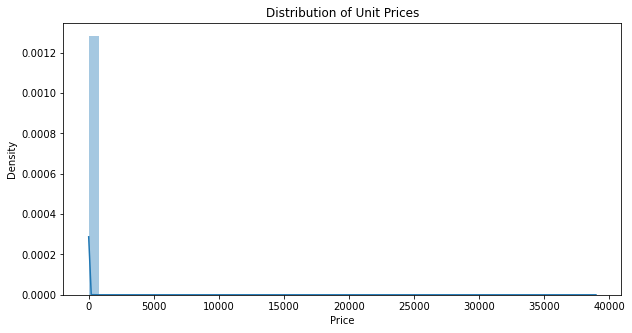

In [10]:
plt.figure(figsize=(10, 5))
sns.distplot(df["UnitPrice"], kde=True)
plt.title("Distribution of Unit Prices")
plt.xlabel("Price");

We can see a large spike around zero, meaning small quantity, but we do also see vary large negative and large postive quantities as well. These negative quantites might not make intuitive sense, but it turns out that that's how cancellations or return are handled. In this case, it looks like someone placed a very large order of 80,000 units, and then that was subsequently cancelled by 80,000 negative quantity.
We should handle with the extreme case, so let's aggregate the data over the year and take the sum of the quantity. Therefore any transaction that are associated with a cancellation or a refund will go away. Also, we can make sure that our final quantities are greater than zero.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


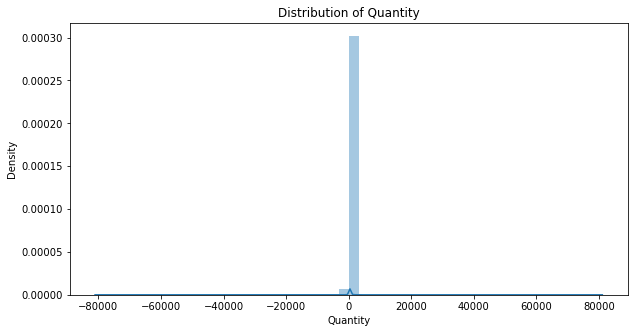

In [12]:
plt.figure(figsize=(10, 5))
sns.distplot(df["Quantity"], kde=True)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity");

Most of our quantities are realteively small (positive) numbers, but there are also some negative quantities as well as extreme outliers (both postiive and negative outliers). 

There are no negative prices, which is good, but we can see some extreme outliers.

In [13]:
df = df.groupby(["StockCode", "Description", "CustomerID", "Country", "UnitPrice"])["Quantity"].sum()
df = df.loc[df > 0].reset_index()
df.shape

(274399, 6)

Now, we still have some categorical features, and we will need to handle them before training a model.
Handling these categorical columns will create many additional columns, resulting in sparse data.
Using sparse matrices can allow us to store all the data without running into memory error.

Since the description column is text-based, we can apply text featurization to it. The method that we will use is TD-IDF, which stands for Term Frequency-Inverse Document Frequency. TD-IDF measures how relavant that term is to the description compared to how relavant it is for all descriptions. 
For example, if we have a descroption of the product "White Metal Lantern". The output of our text featurization will give us a column for each of those words and the values we weighted based off how frequent those words are in other description.

For the "StockCode", "CustomerID", "Country", we will one-hot encode those. These will leave us with very sparse data since most users only buy a small subset of all products. Factorization Machines handles sparse data very well, and it designs for users and products to be one-hot encoded this way.

In [15]:
def loadDataset(dataframe):
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    ohe_output = enc.fit_transform(dataframe[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = dataframe["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(dataframe["Description"])

    row = range(len(dataframe))
    col = [0] * len(dataframe)
    unit_price = csr_matrix((dataframe["UnitPrice"].values, (row, col)), dtype="float32")

    X = hstack([ohe_output, tfidf_output, unit_price], format="csr", dtype="float32")

    y = dataframe["Quantity"].values.astype("float32")

    return X, y

In [16]:
X, y = loadDataset(df)

In [17]:
# display sparsity
total_cells = X.shape[0] * X.shape[1]
(total_cells - X.nnz) / total_cells

0.9991284988048746

Our data is over 99.9% sparse. Because of this high sparsity, the sparse matrix data type allows us to represent our data using only a small fraction of the memory that a dense matrix would require.

In the end, we left a sparse matrix where the rows are each product that the user brought. And our columns are all of our features. Don't worry, Factorization Machines will handle high-sparse data very well. 

## Prepare Data For Modeling

+ Split the data into training and testing sets
+ Write the data to protobuf recordIO format for Pipe mode. [Read more](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html) about protobuf recordIO format. Using this is because Factorization Machines take the protobuf  recordIO format as an input. Using this format allow you to take advantage of pipe mode. In pipe mode, your training data streams data directly from s3. Streaming data can provide faster start times for training jobs and better throughput.


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((219519, 9284), (54880, 9284), (219519,), (54880,))

Save numpy arrays to local storage in /data folder


In [17]:
# df.to_csv("data/online_retail_preprocessed.csv", index=False)
# save_npz("data/X_train.npz", X_train)
# save_npz("data/X_test.npz", X_test)
# np.savez("data/y_train.npz", y_train)
# np.savez("data/y_test.npz", y_test)

In [20]:
prefix = "personalization"

train_key = "train.protobuf"
train_prefix = f"{prefix}/train"

test_key = "test.protobuf"
test_prefix = f"{prefix}/test"

output_prefix = f"s3://{bucket}/{prefix}/output"

In [21]:
def writeDatasetToProtobuf(X, y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, y)
    buf.seek(0)
    obj = "{}/{}".format(prefix, key)
    boto3.resource("s3").Bucket(bucket).Object(obj).upload_fileobj(buf)
    return "s3://{}/{}".format(bucket, obj)


train_data_location = writeDatasetToProtobuf(X_train, y_train, bucket, train_prefix, train_key)
test_data_location = writeDatasetToProtobuf(X_test, y_test, bucket, test_prefix, test_key)

print(train_data_location)
print(test_data_location)
print("Output: {}".format(output_prefix))

s3://sagemaker-us-east-1-267710284436/personalization/train/train.protobuf
s3://sagemaker-us-east-1-267710284436/personalization/test/test.protobuf
Output: s3://sagemaker-us-east-1-267710284436/personalization/output


In [22]:
# %store train_data_location
# %store test_data_location

## Train the factorization machine model

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. 

We'll use the Amazon SageMaker Python SDK to kick off training and monitor status until it is completed. In this example that takes only a few minutes. Despite the model only need 1-2 minutes to train, there is some extra time required upfront to provision hardware and load the algorithm container.

First, let's specify our containers. To find the rigth container, we'll create a small lookup. More details on algorithm containers can be found in [AWS documentation.](https://docs-aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html)

In [24]:
container = sagemaker.image_uris.retrieve("factorization-machines", region=boto_session.region_name)

fm = sagemaker.estimator.Estimator(
    container,
    sagemaker_role,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    output_path=output_prefix,
    sagemaker_session=sagemaker_session,
)

fm.set_hyperparameters(
    feature_dim=X_train.shape[1],
    predictor_type="regressor",
    mini_batch_size=1000,
    num_factors=64,
    epochs=20,
)

In [25]:
if 'training_job_name' not in locals():
    
    fm.fit({'train': train_data_location, 'test': test_data_location})
    training_job_name = fm.latest_training_job.job_name
    %store training_job_name
    
else:
    print(f'Using previous training job: {training_job_name}')

2022-04-15 19:41:57 Starting - Starting the training job...
2022-04-15 19:42:22 Starting - Preparing the instances for trainingProfilerReport-1650051717: InProgress
......
2022-04-15 19:43:25 Downloading - Downloading input data...
2022-04-15 19:43:42 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:120: DeprecationWarning: invalid escape sequence \s
  """
[04/15/2022 19:44:42 INFO 139933643601728 integration.py:636] worker star

Once our model is trained, we will want to use SageMaker ML Lineage Tracking to track different artifacts about the model. 

In [26]:
training_job_info = sagemaker_boto_client.describe_training_job(TrainingJobName=training_job_name)

### Training data artifact

And important aspect of transparency in machine learning is to be able to link a model with code and data used to train it, so we can easily find how any given model was produced. In the event that a model begins to start perfroming poorly, we should be able to quickly find all of all artifacts used to create it, so we can debug to the problem at the source.

To do this, we need to create an artifact for every aspect of training we'd like to save.

First, we will create an artifact containing training data. 

In [27]:
training_data_s3_uri = training_job_info["InputDataConfig"][0]["DataSource"]["S3DataSource"][
    "S3Uri"
]

matching_artifacts = list(
    artifact.Artifact.list(source_uri=training_data_s3_uri, sagemaker_session=sagemaker_session)
)

if matching_artifacts:
    training_data_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {training_data_artifact.artifact_arn}")
else:
    training_data_artifact = artifact.Artifact.create(
        artifact_name="TrainingData",
        source_uri=training_data_s3_uri,
        artifact_type="Dataset",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:267710284436:artifact/354fcb101b03a6f2b0651cd633f7fef5


### Model artifact

Then we will create an artifact containing the model itself. 

In [28]:
trained_model_s3_uri = training_job_info["ModelArtifacts"]["S3ModelArtifacts"]

matching_artifacts = list(
    artifact.Artifact.list(source_uri=trained_model_s3_uri, sagemaker_session=sagemaker_session)
)

if matching_artifacts:
    model_artifact = matching_artifacts[0]
    print(f"Using existing artifact: {model_artifact.artifact_arn}")
else:
    model_artifact = artifact.Artifact.create(
        artifact_name="TrainedModel",
        source_uri=trained_model_s3_uri,
        artifact_type="Model",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {model_artifact.artifact_arn}: SUCCESSFUL")

Using existing artifact: arn:aws:sagemaker:us-east-1:267710284436:artifact/cdb4ea6675f5b2b676783bbddccfb2fa


### Set artifact associations

We can then set the associations for these artifacts.

In [29]:
trial_component = sagemaker_boto_client.describe_trial_component(
    TrialComponentName=training_job_name + "-aws-training-job"
)
trial_component_arn = trial_component["TrialComponentArn"]

### Store artifacts

In [30]:
artifact_list = [[training_data_artifact, "ContributedTo"], [model_artifact, "Produced"]]

for art, assoc in artifact_list:
    try:
        association.Association.create(
            source_arn=art.artifact_arn,
            destination_arn=trial_component_arn,
            association_type=assoc,
            sagemaker_session=sagemaker_session,
        )
        print(f"Association with {art.artifact_type}: SUCCEESFUL")
    except:
        print(f"Association already exists with {art.artifact_type}")

Association already exists with DataSet
Association with Model: SUCCEESFUL


In [31]:
model_name = "retail-recommendations"
model_matches = sagemaker_boto_client.list_models(NameContains=model_name)["Models"]

if not model_matches:
    print(f"Creating model {model_name}")
    model = sagemaker_session.create_model_from_job(
        name=model_name,
        training_job_name=training_job_info["TrainingJobName"],
        role=sagemaker_role,
        image_uri=training_job_info["AlgorithmSpecification"]["TrainingImage"],
    )
else:
    print(f"Model {model_name} already exists.")

Creating model retail-recommendations


## SageMaker Model Registry

Once a useful model has been trained and its artifacts properly associated, the next step is to register the model for future reference and possible deployment. This allows you to gain visibility and reproducibility of the process by which we create the models. 

### Create Model Package Group

A Model Package Groups holds multiple versions or iterations of a model. Though it is not required to create them for every model in the registry, they help organize various models which all have the same purpose and provide autiomatic versioning.


We create model package group that contains different version of a model. You can register each model you train, and the model registry adds it to the model group as a new model version. If you plan on tracking multiple version of a model, you need to create a model package group first.

In [34]:
if 'mpg_name' not in locals():
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M')
    mpg_name = f'retail-recommendation-{timestamp}'
    %store mpg_name

print(f'Model Package Group name: {mpg_name}')

Stored 'mpg_name' (str)
Model Package Group name: retail-recommendation-2022-04-15-20-10


In [35]:
mpg_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageGroupDescription": "Recommendation for Online Retail Sales",
}

In [36]:
matching_mpg = sagemaker_boto_client.list_model_package_groups(NameContains=mpg_name)[
    "ModelPackageGroupSummaryList"
]

if matching_mpg:
    print(f"Using existing Model Package Group: {mpg_name}")
else:
    mpg_response = sagemaker_boto_client.create_model_package_group(**mpg_input_dict)
    print(f"Create Model Package Group {mpg_name}: SUCCESSFUL")

Create Model Package Group retail-recommendation-2022-04-15-20-10: SUCCESSFUL


Once the model package group has been created, you can now add the first version of your trained model to it.
We will only show one version of a model here, but in practice, you may have different versions as you try different features, different hyperparameters, or even update your model over time. 

Along with s3 location of the trained model, you need to add the inference specification, so we know what Docker image to use to deploy the model and make the prediction. 
We can also use various training metrics like training and validation, group mean square error. 

Here we inlcude every metric that is associated with our training job. 

In [38]:
model_metrics_report = {"regression_metrics": {}}

for metric in training_job_info["FinalMetricDataList"]:
    stat = {metric["MetricName"]: {"value": metric["Value"]}}
    model_metrics_report["regression_metrics"].update(stat)

with open("training_metrics.json", "w") as f:
    json.dump(model_metrics_report, f)

metrics_s3_key = f"training_jobs/{training_job_info['TrainingJobName']}/training_metrics.json"
s3_client.upload_file(Filename="training_metrics.json", Bucket=bucket, Key=metrics_s3_key)

#### Define the inference spec

In [39]:
mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_job_info["AlgorithmSpecification"]["TrainingImage"],
    supports_gpu=False,
    supported_content_types=["application/x-recordio-protobuf", "application/json"],
    supported_mime_types=["text/csv"],
)

mp_inference_spec["InferenceSpecification"]["Containers"][0]["ModelDataUrl"] = training_job_info[
    "ModelArtifacts"
]["S3ModelArtifacts"]

#### Define model metrics

Metrics other than model quality can be defined. See the Boto3 documentation for [creating a model package](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model_package).

In [40]:
model_metrics = {
    "ModelQuality": {
        "Statistics": {
            "ContentType": "application/json",
            "S3Uri": f"s3://{bucket}/{metrics_s3_key}",
        }
    }
}

Finally, for model governance reasons, you can tag the model package with a status, it's easy to tell which models are actually approved or declined for deployment into production. 
Here we tage "PendingManualApproval".

In [41]:
mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "Factorization Machine Model to create personalized retail recommendations",
    "ModelApprovalStatus": "PendingManualApproval",
    "ModelMetrics": model_metrics,
}

mp_input_dict.update(mp_inference_spec)
mp_response = sagemaker_boto_client.create_model_package(**mp_input_dict)

### Wait until model package is completed

In [42]:
mp_info = sagemaker_boto_client.describe_model_package(
    ModelPackageName=mp_response["ModelPackageArn"]
)
mp_status = mp_info["ModelPackageStatus"]

while mp_status not in ["Completed", "Failed"]:
    time.sleep(5)
    mp_info = sagemaker_boto_client.describe_model_package(
        ModelPackageName=mp_response["ModelPackageArn"]
    )
    mp_status = mp_info["ModelPackageStatus"]
    print(f"model package status: {mp_status}")
print(f"model package status: {mp_status}")

model package status: Completed


In [43]:
model_package = sagemaker_boto_client.list_model_packages(ModelPackageGroupName=mpg_name)[
    "ModelPackageSummaryList"
][0]
model_package_update = {
    "ModelPackageArn": model_package["ModelPackageArn"],
    "ModelApprovalStatus": "Approved",
}

update_response = sagemaker_boto_client.update_model_package(**model_package_update)

### Create endpoint config and endpoint

In [51]:
primary_container = {'ModelPackageName' : model_package['ModelPackageArn']}
endpoint_config_name = f'{model_name}-endpoint-config'
existing_configs = sagemaker_boto_client.list_endpoint_configs(NameContains = endpoint_config_name)['EndpointConfigs']

if not existing_configs:
    create_ep_config_response = sagemaker_boto_client.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "InstanceType": 'ml.m4.4xlarge',
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "ModelName": model_name,
                "VariantName": "AllTraffic",
            }]
    )
    %store endpoint_config_name
    

endpoint_name = f'{model_name}-endpoint'
existing_endpoints = sagemaker_boto_client.list_endpoints(NameContains=endpoint_name)["Endpoints"]

if not existing_endpoints:
    create_endpoint_response = sagemaker_boto_client.create_endpoint(
        EndpointName=endpoint_name, 
        EndpointConfigName=endpoint_config_name)
     

endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=endpoint_name)
endpoint_status = endpoint_info["EndpointStatus"]

while endpoint_status == "Creating":
    endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=endpoint_name)
    endpoint_status = endpoint_info["EndpointStatus"]
    print("Endpoint status:", endpoint_status)
    if endpoint_status == "Creating":
        time.sleep(60)


Stored 'endpoint_config_name' (str)
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: Creating
Endpoint status: InService


## Make Predictions

Now that we've trained our model, we can deploy it behind an Amazon SageMaker real-time hosted endpoint. This will allow out to make predictions (or inference) from the model dyanamically.

Note, Amazon SageMaker allows you the flexibility of importing models trained elsewhere, as well as the choice of not importing models if the target of model creation is AWS Lambda, AWS Greengrass, Amazon Redshift, Amazon Athena, or other deployment target.

Here we will take the top customer, the customer who spent the most money, and try to find which items to recommend to them.

In [53]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

In [54]:
class FMSerializer(JSONSerializer):
    def serialize(self, data):
        js = {"instances": []}
        for row in data:
            js["instances"].append({"features": row.tolist()})
        return json.dumps(js)


fm_predictor = fm.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=FMSerializer(),
    deserializer=JSONDeserializer(),
)

-----------!

In [55]:
# find customer who spent the most money

df["invoice_amount"] = df["Quantity"] * df["UnitPrice"]
top_customer = (
    df.groupby("CustomerID").sum()["invoice_amount"].sort_values(ascending=False).index[0]
)

In [56]:
def get_recommendations(df, customer_id, n_recommendations, n_ranks=100):
    popular_items = (
        df.groupby(["StockCode", "UnitPrice"])
        .nunique()["CustomerID"]
        .sort_values(ascending=False)
        .reset_index()
    )
    top_n_items = popular_items["StockCode"].iloc[:n_ranks].values
    top_n_prices = popular_items["UnitPrice"].iloc[:n_ranks].values

    # stock codes can have multiple descriptions, so we will choose whichever description is most common
    item_map = df.groupby("StockCode").agg(lambda x: x.value_counts().index[0])["Description"]

    # find customer's country
    df_subset = df.loc[df["CustomerID"] == customer_id]
    country = df_subset["Country"].value_counts().index[0]

    data = {
        "StockCode": top_n_items,
        "Description": [item_map[i] for i in top_n_items],
        "CustomerID": customer_id,
        "Country": country,
        "UnitPrice": top_n_prices,
    }

    df_inference = pd.DataFrame(data)

    # we need to build the data set similar to how we built it for training
    # it should have the same number of features as the training data
    enc = OneHotEncoder(handle_unknown="ignore")
    onehot_cols = ["StockCode", "CustomerID", "Country"]
    enc.fit(df[onehot_cols])
    onehot_output = enc.transform(df_inference[onehot_cols])

    vectorizer = TfidfVectorizer(min_df=2)
    unique_descriptions = df["Description"].unique()
    vectorizer.fit(unique_descriptions)
    tfidf_output = vectorizer.transform(df_inference["Description"])

    row = range(len(df_inference))
    col = [0] * len(df_inference)
    unit_price = csr_matrix((df_inference["UnitPrice"].values, (row, col)), dtype="float32")

    X_inference = hstack([onehot_output, tfidf_output, unit_price], format="csr")

    result = fm_predictor.predict(X_inference.toarray())
    preds = [i["score"] for i in result["predictions"]]
    index_array = np.array(preds).argsort()
    items = enc.inverse_transform(onehot_output)[:, 0]
    top_recs = np.take_along_axis(items, index_array, axis=0)[: -n_recommendations - 1 : -1]
    recommendations = [[i, item_map[i]] for i in top_recs]
    return recommendations

In [57]:
print("Top 5 recommended products:")
get_recommendations(df, top_customer, n_recommendations=5, n_ranks=100)

Top 5 recommended products:


[['22423', 'REGENCY CAKESTAND 3 TIER'],
 ['22776', 'SWEETHEART CAKESTAND 3 TIER'],
 ['22624', 'IVORY KITCHEN SCALES'],
 ['85123A', 'WHITE HANGING HEART T-LIGHT HOLDER'],
 ['85099B', 'JUMBO BAG RED RETROSPOT']]

## Build Pipeline

Now that we are comfotable with the model that we built.
Model training is not one-and-done task. You will want to improve your model with new data as well as changes in customer purchase behavior over time. Improving models takes thousands of repetitions of all the steps we just went through. 
Having these steps automated using Pipielines allows to reply the whole workflow with single click and save hours of manual work.

First let's upload our raw data to s3.

In [58]:
base_uri = f"s3://{bucket}/data"
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path="data/Online Retail.csv", desired_s3_uri=base_uri
)

input_data = ParameterString(name="InputData", default_value=input_data_uri)

We will then set a model approvel status of Approved, meaning this model is approved for production. 
In pracitice, you might want to set this to Pending manual approval, so that someone needs to go in and manually approve the model for production later.

In [59]:
model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)

Next, we define a customeized step for preprocessing  our data. Our preprocessing.py file has all the transmation that we perfromed above, including spiltting the data into training and testing sets and saving them to protobuf format. 
We specify the outputs to contain both the training data and testing data, so we can use them in subsequent steps.

In [60]:
create_dataset_script_uri = f"s3://{bucket}/{prefix}/code/preprocessing.py"
s3_client.upload_file(
    Filename="preprocessing.py", Bucket=bucket, Key=f"{prefix}/code/preprocessing.py"
)

sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="sklearn-retail-sales-process",
    role=sagemaker_role,
)

create_dataset_step = ProcessingStep(
    name="PreprocessData",
    processor=sklearn_processor,
    inputs=[
        sagemaker.processing.ProcessingInput(
            source=input_data, destination="/opt/ml/processing/input"
        ),
    ],
    outputs=[
        sagemaker.processing.ProcessingOutput(
            output_name="train_data", source="/opt/ml/processing/output/train"
        ),
        sagemaker.processing.ProcessingOutput(
            output_name="test_data", source="/opt/ml/processing/output/test"
        ),
    ],
    code=create_dataset_script_uri,
)

SageMaker comes with a pre-made training step in the SageMaker SDK, which abstracts away most of the generic processor code. All we need to give this step is the estimator and an input, which, in this case, is the training and testing data. 
These are the same training and testing data that we created above. 

In [61]:
train_step = TrainingStep(
    name="TrainingStep",
    estimator=fm,
    inputs={
        "train": sagemaker.inputs.TrainingInput(
            s3_data=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
                "train_data"
            ].S3Output.S3Uri
        ),
        "test": sagemaker.inputs.TrainingInput(
            s3_data=create_dataset_step.properties.ProcessingOutputConfig.Outputs[
                "test_data"
            ].S3Output.S3Uri
        ),
    },
)

In [62]:
model = sagemaker.model.Model(
    name="retail-personalization-factorization-machine",
    image_uri=train_step.properties.AlgorithmSpecification.TrainingImage,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=sagemaker_role,
)

inputs = sagemaker.inputs.CreateModelInput(instance_type="ml.m4.xlarge")

create_model_step = CreateModelStep(name="CreateModel", model=model, inputs=inputs)

In [63]:
register_step = RegisterModel(
    name="RegisterModel",
    estimator=fm,
    model_data=train_step.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/x-recordio-protobuf", "application/json"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=mpg_name,
    approval_status=model_approval_status,
)

In [64]:
s3_client.upload_file(Filename="deploy.py", Bucket=bucket, Key=f"{prefix}/code/deploy.py")
deploy_script_uri = f"s3://{bucket}/{prefix}/code/deploy.py"

deployment_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=sagemaker_role,
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name=f"{prefix}-deploy",
    sagemaker_session=sagemaker_session,
)

deploy_step = ProcessingStep(
    name="DeployModel",
    processor=deployment_processor,
    job_arguments=[
        "--model-name",
        create_model_step.properties.ModelName,
        "--region",
        region,
        "--endpoint-instance-type",
        "ml.m4.xlarge",
        "--endpoint-name",
        "retail-recommendation-endpoint",
    ],
    code=deploy_script_uri,
)

In [65]:
pipeline_name = f"PersonalizationDemo"
%store pipeline_name

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[input_data, model_approval_status],
    steps=[create_dataset_step, train_step, create_model_step, register_step, deploy_step],
)

Stored 'pipeline_name' (str)


In [68]:
pipeline.upsert(role_arn=sagemaker_role)

TypeError: expected string or bytes-like object

In [67]:
start_response = pipeline.start()
start_response.wait()
start_response.describe()

ValueError: This pipeline is not associated with a Pipeline in SageMaker. Please invoke create() first before attempting to invoke start().